In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.constants import c, k_B, M_sun, G, m_p, sigma_sb, m_p
import astropy.units as u
from scipy.sparse import csr_matrix
import numpy as np
import numba
import sys

sys.path.append('../Numerical_methods')
from bachelor_funcs import Σ_initial, c_s2, α_φz_func, opacity, find_temp
from unchanged_values import Ω, r_au, T_req

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)

### Temperature bith viscous heating and stellar irradiation
$$T^4 = T_{vis}^4 + T_{req}^4$$
$$T_{req}=T_{1au}\left(\frac{r}{1au}\right)^p$$

### Temperature at midplane for MRI-active PPDs
$$T_{vis}^4 = \frac{1}{2\sigma_{SB}}\left(\frac{3}{8}\tau_R+\frac{1}{3\tau_P}\right)F_{rad}$$
$$\tau_R=\kappa_R\Sigma/2$$
### $\kappa_R:$
$$\kappa_R = 4.5(T/150K)^2\;cm^2g^{-1}\quad T<150K$$
$$\kappa_R = 4.5\;cm^2g^{-1}\quad 150K \leq T \leq1500K$$
$$\kappa_R = 0\;cm^2g^{-1}\quad 1500K<T$$

$$\tau_P = max(2.4\tau_R,\;0.5)$$
### $F_{rad}$ for the weak DW case (p. 4 Suzuki)
$$F_{rad} = \epsilon_{rad}\left[\frac{3}{2}\Omega\Sigmaα_{rφ}c_s^2 + r\Omegaα_{\phi z}(\rho c_s^2)_{mid}\right],\quad\epsilon_{rad}=0.9$$
$$\Sigma \Omega=\sqrt{2 \pi}(\rho c_s)_{mid}\quad \Rightarrow \quad (\rho c_s)_{mid}=\frac{1}{\sqrt{2 \pi}}\Sigma \Omega
\quad ?\;\Rightarrow\quad (\rho c_s^2)_{mid} = \frac{c_s}{\sqrt{2 \pi}}\Sigma \Omega$$
$$\frac{g}{cm^2}\frac{1}{s} = \frac{kg}{m^3}\frac{m}{s}$$ 



In [2]:
def F_rad_weakDW(T, Σ, α_φz, α_rφ = 8e-10, ε_rad = 0.9):
    return ε_rad * (3/2 * Ω * Σ * α_rφ * c_s2(T) + r_au * Ω * α_φz * np.sqrt(c_s2(T)) / np.sqrt(2*np.pi) * Σ * Ω).to(('W/m2'))

In [3]:
F_rad_weakDW(T_req, Σ_initial(r_au),  α_φz_func(Σ_initial(r_au)))

<Quantity [1.13718928e+008, 9.56258019e+007, 8.04113032e+007,
           6.76174474e+007, 5.68591141e+007, 4.78124539e+007,
           4.02051410e+007, 3.38081758e+007, 2.84289918e+007,
           2.39056597e+007, 2.01020125e+007, 1.69035473e+007,
           1.42139785e+007, 1.19523394e+007, 1.00505451e+007,
           8.45134300e+006, 7.10658934e+006, 5.97580015e+006,
           5.02493249e+006, 4.22535973e+006, 3.55300977e+006,
           2.98764049e+006, 2.51223034e+006, 2.11246597e+006,
           1.77631136e+006, 1.49364547e+006, 1.25595760e+006,
           1.05609115e+006, 8.88028195e+005, 7.46708298e+005,
           6.27876198e+005, 5.27953686e+005, 4.43931884e+005,
           3.73280664e+005, 3.13872473e+005, 2.63918284e+005,
           2.21913729e+005, 1.86593809e+005, 1.56894812e+005,
           1.31922279e+005, 1.10924080e+005, 9.32677638e+004,
           7.84215166e+004, 6.59381499e+004, 5.54416343e+004,
           4.66157772e+004, 3.91947017e+004, 3.29548400e+004,
        

In [4]:
def T_vis_weakDW(T, Σ, α_φz):
    return (opacity(T, Σ) * ((0.5 * sigma_sb**(-1)) * F_rad_weakDW(T, Σ, α_φz))**(0.25)).decompose()

In [5]:
T_vis_weakDW(T_req, Σ_initial(r_au), α_φz_func(Σ_initial(r_au)))

<Quantity [5.62727003e+03, 5.38869173e+03, 5.16022742e+03, 4.94144835e+03,
           4.73194392e+03, 4.53132096e+03, 4.33920296e+03, 4.15522936e+03,
           3.97905490e+03, 3.81034895e+03, 3.64879489e+03, 3.49408954e+03,
           3.34594256e+03, 3.20407591e+03, 3.06822335e+03, 2.93812994e+03,
           2.81355152e+03, 2.69425429e+03, 2.58001437e+03, 2.47061736e+03,
           2.36585796e+03, 2.26553957e+03, 2.16947391e+03, 2.07748369e+03,
           1.99190367e+03, 2.66620124e+03, 1.28516763e+04, 5.29769767e+04,
           6.33051614e+04, 5.96246842e+04, 5.61146151e+04, 5.28110148e+04,
           4.97018310e+04, 4.67756236e+04, 4.40216254e+04, 4.14297028e+04,
           3.89903185e+04, 3.66944965e+04, 3.45337887e+04, 3.25002445e+04,
           3.05863809e+04, 2.87851552e+04, 2.70899392e+04, 2.54944948e+04,
           2.39929507e+04, 2.25797814e+04, 2.12497864e+04, 1.99980712e+04,
           1.88200293e+04, 1.77113253e+04, 1.66678790e+04, 1.56858500e+04,
           1.47616243e+04

In [6]:
T_req

<Quantity [2800.        , 2736.05350835, 2673.56742878, 2612.50840833,
           2552.8438558 , 2494.54192426, 2437.57149415, 2381.90215658,
           2327.50419717, 2274.34858013, 2222.40693282, 2171.65153055,
           2122.05528182, 2073.59171383, 2026.2349584 , 1979.9597381 ,
           1934.7413528 , 1890.55566646, 1847.37909427, 1805.18859005,
           1763.96163395, 1723.67622042, 1684.31084648, 1645.84450024,
           1608.25664967, 1571.52723167, 1535.63664131, 1500.56572144,
           1466.29575238, 1432.80844199, 1400.0859159 , 1368.11070792,
           1336.8657508 , 1306.33436703, 1276.50025999, 1247.34750528,
           1218.86054212, 1191.02416517, 1163.8235163 , 1137.24407675,
           1111.2716593 , 1085.89240077, 1061.09275458, 1036.85948352,
           1013.1796527 ,  990.04062263,  967.43004249,  945.33584351,
            923.74623258,  902.64968588,  882.03494281,  861.89099992,
            842.20710505,  822.97275162,  804.17767298,  785.81183697,
      

In [15]:
T0_MRI_inactive_weakDW_Σtorque = np.genfromtxt('..\Temperature_presets\T0_MRI_inactive_weakDW_Σtorque.csv') * u.K

In [16]:
T0_strongDW_inactive = np.genfromtxt('..\Temperature_presets\T0_MRI_inactive_strongDW.csv') * u.K

K


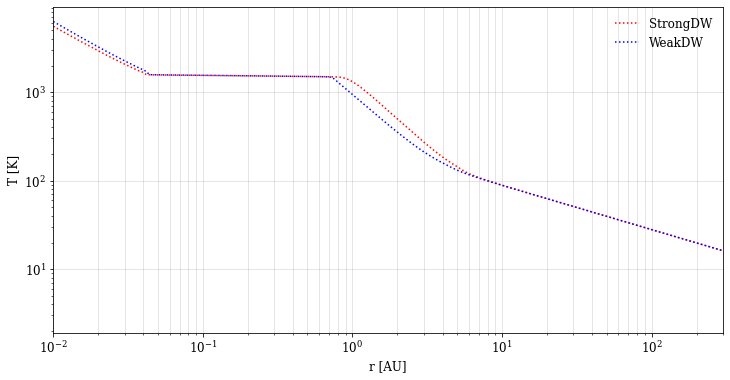

In [19]:
fig, axs = plt.subplots(figsize = (12, 6))
axs.loglog(r_au, T0_strongDW_inactive, ':', label = 'StrongDW', c = 'red')
axs.loglog(r_au, T0_MRI_inactive_weakDW_Σtorque, ':', label = 'WeakDW', c = 'blue')

axs.grid(axis = 'x', which = 'both', alpha = 0.4)
axs.grid(axis = 'y', which = 'major', alpha = 0.4)
axs.set(xlim = (0.01, 300), xlabel = 'r [AU]', ylabel = 'T [K]');
print(T0_strongDW_inactive.unit)
axs.legend(frameon = False)